In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import imageio
import cv2
from tqdm import tqdm, tqdm_notebook
import random
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
from keras.preprocessing.image import img_to_array

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
artists = pd.read_csv('/content/drive/My Drive/SI670_Project/artists.csv')
artists.shape

(50, 8)

In [5]:
artists.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


####Data Pre-processing

In [6]:
# Sort artists by number of paintings
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
artists_top = artists[artists['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]
#artists_top['class_weight'] = max(artists_top.paintings)/artists_top.paintings
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
artists_top.head(20)

,name,paintings,class_weight
0,Vincent van Gogh,877,0.445631
1,Edgar Degas,702,0.556721
2,Pablo Picasso,439,0.890246
3,Pierre-Auguste Renoir,336,1.163149
4,Albrecht Dürer,328,1.191519
5,Paul Gauguin,311,1.256650
6,Francisco Goya,291,1.343018
7,Rembrandt,262,1.491672
8,Alfred Sisley,259,1.508951
9,Titian,255,1.532620


In [7]:

class_weights = artists_top['class_weight'].to_dict()
class_weights

{0: 0.44563076604125634,
 1: 0.5567210567210568,
 2: 0.8902464278318493,
 3: 1.1631493506493507,
 4: 1.1915188470066518,
 5: 1.2566501023092662,
 6: 1.3430178069353327,
 7: 1.491672449687717,
 8: 1.5089505089505089,
 9: 1.532620320855615,
 10: 1.6352225180677062}

In [0]:

# Explore images of top artists
images_dir = '/content/drive/My Drive/SI670_Project/images.zip (Unzipped Files)/images'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values



In [9]:
artists_top_name.shape

(11,)

In [0]:
artists_map = {v:k for k, v in enumerate(list(artists_top_name))}

In [0]:
image_size = 128
def train_data():
    train_data = []
    y = []
    for name in artists_top_name:
      if os.path.exists(os.path.join(images_dir, name)):
        for image1 in tqdm(os.listdir(os.path.join(images_dir, name))): 
          try:
            path = os.path.join(images_dir, name, image1)
            #print(path)
            img1 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
            img1 = cv2.resize(img1, (image_size, image_size))
            train_data.append(img1) 
            y.append(artists_map[name])
          except:
            pass
    # df = pd.DataFrame(train_data)
    # df['y'] = pd.Series(y)
    return train_data, y

In [0]:
df = train_data() 

100%|██████████| 240/240 [00:01<00:00, 131.96it/s]


In [0]:
X = np.vstack(df[0])

In [0]:
x_flatten = X.reshape(len(df[0]),df[0][1].shape[0]*df[0][1].shape[1])

In [0]:
x_flatten.shape

(4299, 16384)

In [0]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_flatten, np.array(df[1]), test_size=0.2, random_state=42)
number_of_train = x_train.shape[0]
number_of_test = x_test.shape[0]
print(number_of_train)
print(number_of_test)


3439
860


### Linear Classifier

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
clf=LogisticRegression()
clf.fit(x_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
print("test accuracy: {} ".format(clf.score(x_test, y_test)))


test accuracy: 0.27906976744186046 


In [0]:
from sklearn.metrics import classification_report
y_pred = clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=artists_map.keys()))

                       precision    recall  f1-score   support

     Vincent_van_Gogh       0.36      0.30      0.33       188
          Edgar_Degas       0.27      0.31      0.29       153
        Pablo_Picasso       0.24      0.22      0.23        83
Pierre-Auguste_Renoir       0.18      0.18      0.18        67
       Albrecht_Dürer       0.29      0.36      0.32        74
         Paul_Gauguin       0.10      0.14      0.11        51
       Francisco_Goya       0.35      0.37      0.36        51
            Rembrandt       0.31      0.36      0.33        50
        Alfred_Sisley       0.16      0.18      0.17        51
               Titian       0.45      0.25      0.33        51
         Marc_Chagall       0.63      0.29      0.40        41

             accuracy                           0.28       860
            macro avg       0.30      0.27      0.28       860
         weighted avg       0.30      0.28      0.28       860



In [0]:
y_test.shape

(860,)

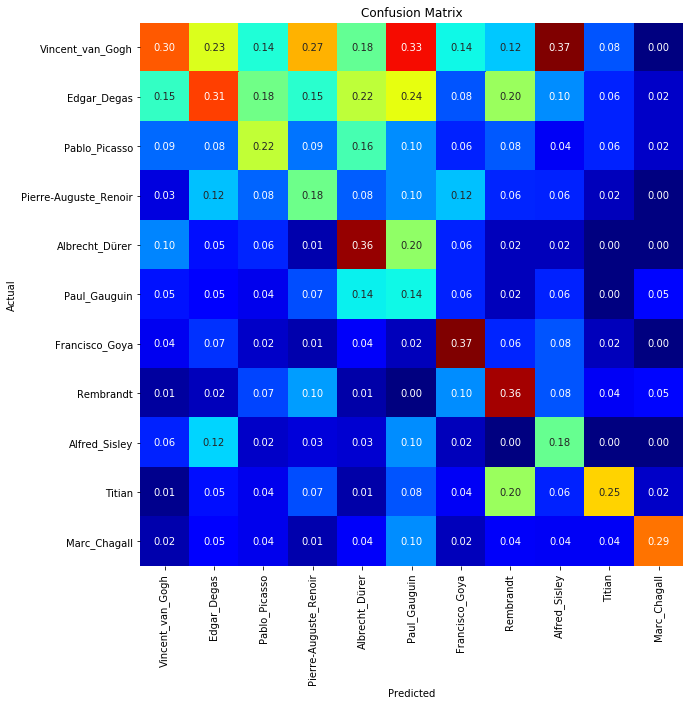

In [0]:
# Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(list(y_test), list(y_pred))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()

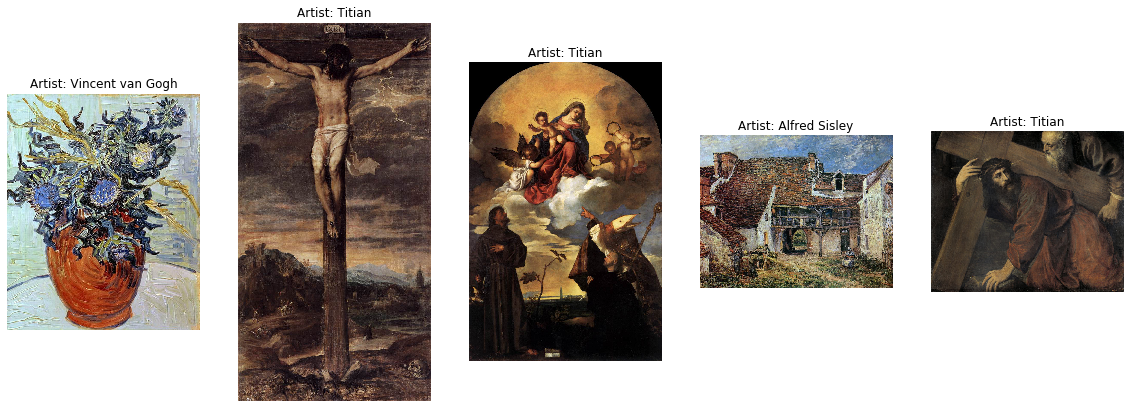

In [12]:
# Print few random paintings
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()

In [13]:
# Augment data
batch_size = 16
train_input_shape = (224, 224, 3)
n_classes = artists_top.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   #rotation_range=45,
                                   #width_shift_range=0.5,
                                   #height_shift_range=0.5,
                                   shear_range=5,
                                   #zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 3444 images belonging to 11 classes.
Found 855 images belonging to 11 classes.
Total number of batches = 215 and 53


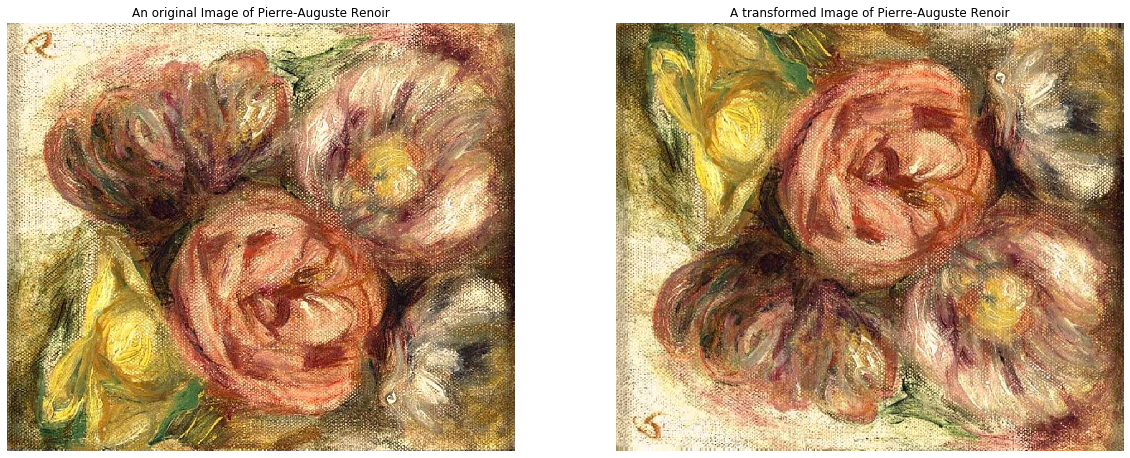

In [14]:
# Print a random paintings and it's random augmented version
fig, axes = plt.subplots(1, 2, figsize=(20,10))

random_artist = random.choice(artists_top_name)
random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
random_image_file = os.path.join(images_dir, random_artist, random_image)

# Original image
image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("An original Image of " + random_artist.replace('_', ' '))
axes[0].axis('off')

# Transformed image
aug_image = train_datagen.random_transform(image)
axes[1].imshow(aug_image)
axes[1].set_title("A transformed Image of " + random_artist.replace('_', ' '))
axes[1].axis('off')

plt.show()

###ResNet Model

In [15]:
# Load pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
94773248/94765736 [==============================] - 1s 0us/step


In [0]:
# Add layers at the end
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

In [0]:
optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [0]:
n_epoch = 10

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [19]:
# Train the model - all layers
history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )
model.save_weights('model_weights_history1.h5')


Epoch 1/10
215/215 [==============================] - 171s 797ms/step - loss: 1.5439 - acc: 0.5455 - val_loss: 2.4972 - val_acc: 0.0613
Epoch 2/10
215/215 [==============================] - 76s 356ms/step - loss: 1.0839 - acc: 0.7588 - val_loss: 2.6128 - val_acc: 0.0755
Epoch 3/10
215/215 [==============================] - 79s 365ms/step - loss: 0.9805 - acc: 0.7975 - val_loss: 2.6768 - val_acc: 0.0873
Epoch 4/10
215/215 [==============================] - 79s 368ms/step - loss: 0.8863 - acc: 0.8235 - val_loss: 1.9710 - val_acc: 0.3856
Epoch 5/10
215/215 [==============================] - 80s 373ms/step - loss: 0.7584 - acc: 0.8617 - val_loss: 1.3678 - val_acc: 0.6368
Epoch 6/10
Epoch 1/10
215/215 [==============================] - 81s 377ms/step - loss: 0.6724 - acc: 0.8909 - val_loss: 0.9500 - val_acc: 0.7901
Epoch 7/10
215/215 [==============================] - 82s 381ms/step - loss: 0.5978 - acc: 0.8973 - val_loss: 0.9779 - val_acc: 0.7759
Epoch 8/10
215/215 [=======================

In [0]:
# history1 = model.load_weights('/content/drive/My Drive/SI670_Project/model_weights_history1.h5')

In [0]:
# Freeze core ResNet layers and train again 
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[:50]:
    layer.trainable = True

optimizer = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])



In [0]:
n_epoch = 50
history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )
model.save_weights('model_weights_history2.h5')

Epoch 1/50
215/215 [==============================] - 123s 573ms/step - loss: 0.3511 - acc: 0.9600 - val_loss: 0.7637 - val_acc: 0.7995
Epoch 2/50
215/215 [==============================] - 104s 485ms/step - loss: 0.3733 - acc: 0.9475 - val_loss: 0.7737 - val_acc: 0.8149
Epoch 3/50
215/215 [==============================] - 103s 478ms/step - loss: 0.3542 - acc: 0.9548 - val_loss: 0.7173 - val_acc: 0.8491
Epoch 4/50
215/215 [==============================] - 110s 512ms/step - loss: 0.3694 - acc: 0.9501 - val_loss: 0.7104 - val_acc: 0.8384
Epoch 5/50
215/215 [==============================] - 105s 488ms/step - loss: 0.3629 - acc: 0.9527 - val_loss: 0.6910 - val_acc: 0.8408
Epoch 6/50
215/215 [==============================] - 107s 496ms/step - loss: 0.3614 - acc: 0.9557 - val_loss: 0.7043 - val_acc: 0.8302
Epoch 7/50
215/215 [==============================] - 107s 500ms/step - loss: 0.3544 - acc: 0.9595 - val_loss: 0.7098 - val_acc: 0.8196
Epoch 8/50
215/215 [============================

In [0]:
# history2 = model.load_weights('/content/drive/My Drive/SI670_Project/model_weights_history2.h5')

In [0]:
# Merge history1 and history2
history = {}
history['loss'] = history1.history['loss'] + history2.history['loss']
history['acc'] = history1.history['acc'] + history2.history['acc']
history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss']
history['val_acc'] = history1.history['val_acc'] + history2.history['val_acc']
history['lr'] = history1.history['lr'] + history2.history['lr']

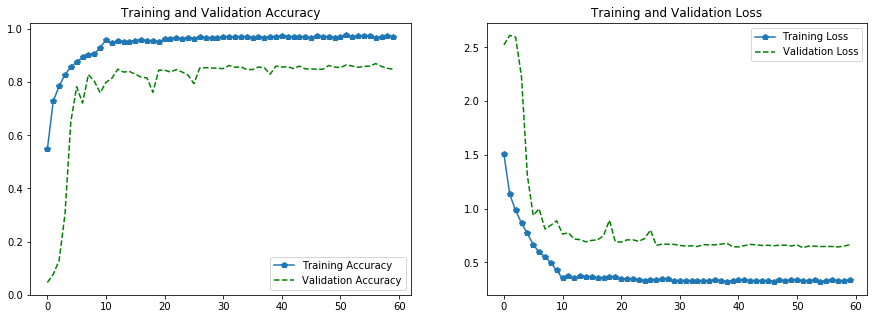

In [0]:
# Plot the training graph
def plot_training(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'p-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'g--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'p-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'g--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    
plot_training(history)

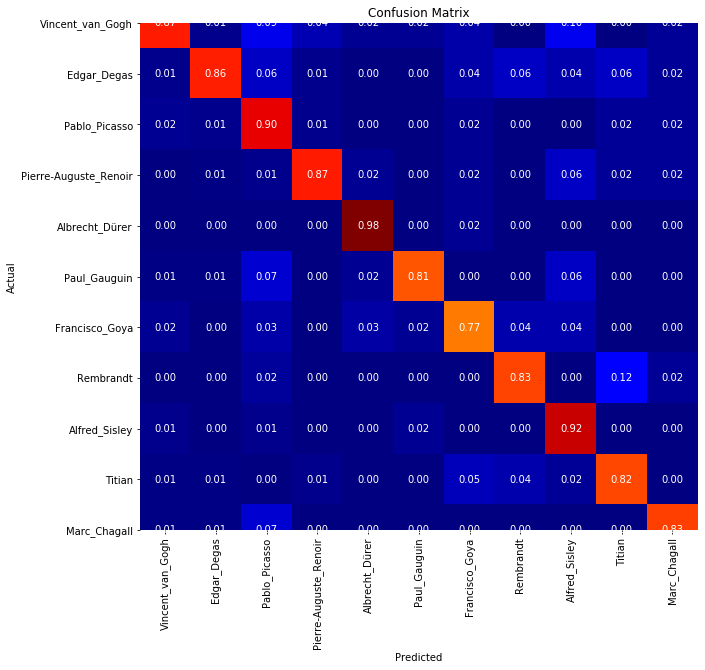

Classification Report:
                       precision    recall  f1-score   support

     Vincent_van_Gogh       0.92      0.87      0.89       173
          Edgar_Degas       0.94      0.86      0.90       139
        Pablo_Picasso       0.71      0.90      0.79        86
Pierre-Auguste_Renoir       0.91      0.87      0.89        67
       Albrecht_Dürer       0.93      0.98      0.96        65
         Paul_Gauguin       0.94      0.81      0.87        62
       Francisco_Goya       0.81      0.77      0.79        56
            Rembrandt       0.86      0.83      0.84        52
        Alfred_Sisley       0.75      0.92      0.82        51
               Titian       0.79      0.82      0.80        50
         Marc_Chagall       0.89      0.83      0.86        47

             accuracy                           0.86       848
            macro avg       0.86      0.86      0.86       848
         weighted avg       0.87      0.86      0.86       848



In [0]:
# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

tick_labels = artists_top_name.tolist()

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=artists_top_name.tolist()))

showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)


Predicted artist = Marc Chagall
Prediction probability = 34.980615973472595 %


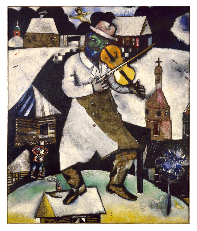

In [0]:
# Replace 'url' with any image of one of the 11 artists above and run this cell.
url = '/content/drive/My Drive/SI670_Project/Classification Images/Image-Chagall_Fiddler.jpg'

web_image = imageio.imread(url)
web_image = cv2.resize(web_image, dsize=train_input_shape[0:2], )
web_image = img_to_array(web_image)
web_image /= 255.
web_image = np.expand_dims(web_image, axis=0)


prediction = model.predict(web_image)
prediction_probability = np.amax(prediction)
prediction_idx = np.argmax(prediction)

print("Predicted artist =", tick_labels[prediction_idx].replace('_', ' '))
print("Prediction probability =", prediction_probability*100, "%")

plt.imshow(imageio.imread(url))
plt.axis('off')
plt.show()

Predicted artist = Titian
Prediction probability = 91.80660247802734 %


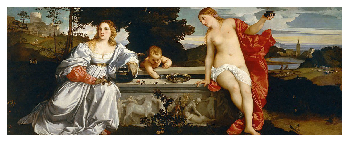

In [0]:
# Replace 'url' with any image of one of the 11 artists above and run this cell.
url = '/content/drive/My Drive/SI670_Project/Classification Images/Titian-Famous-Paintings-Featured.jpg'

web_image = imageio.imread(url)
web_image = cv2.resize(web_image, dsize=train_input_shape[0:2], )
web_image = img_to_array(web_image)
web_image /= 255.
web_image = np.expand_dims(web_image, axis=0)


prediction = model.predict(web_image)
prediction_probability = np.amax(prediction)
prediction_idx = np.argmax(prediction)

print("Predicted artist =", tick_labels[prediction_idx].replace('_', ' '))
print("Prediction probability =", prediction_probability*100, "%")

plt.imshow(imageio.imread(url))
plt.axis('off')
plt.show()

Predicted artist = Vincent van Gogh
Prediction probability = 61.69854402542114 %


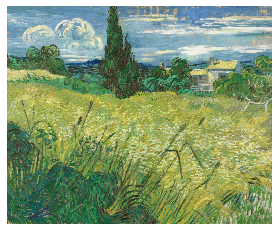

In [0]:
# Replace 'url' with any image of one of the 11 artists above and run this cell.
url = '/content/drive/My Drive/SI670_Project/Classification Images/Vincent_van_Gogh_-_Green_Field_-_Google_Art_Project.jpg'

web_image = imageio.imread(url)
web_image = cv2.resize(web_image, dsize=train_input_shape[0:2], )
web_image = img_to_array(web_image)
web_image /= 255.
web_image = np.expand_dims(web_image, axis=0)


prediction = model.predict(web_image)
prediction_probability = np.amax(prediction)
prediction_idx = np.argmax(prediction)

print("Predicted artist =", tick_labels[prediction_idx].replace('_', ' '))
print("Prediction probability =", prediction_probability*100, "%")

plt.imshow(imageio.imread(url))
plt.axis('off')
plt.show()

### MobileNet Model

In [0]:
# Load pre-trained model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

In [0]:
# Add layers at the end
X = base_model.output
X = tf.keras.layers.Flatten()(X)

X = tf.keras.layers.Dense(512, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Activation('relu')(X)

X = tf.keras.layers.Dense(16, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Activation('relu')(X)

output = tf.keras.layers.Dense(n_classes, activation='softmax')(X)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [0]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [0]:
optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [0]:
history = model.fit_generator(
    generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
    epochs=10,
    shuffle=True,
    verbose=5,
    callbacks=[reduce_lr],
    use_multiprocessing=True,
    workers=16,
    class_weight=class_weights
)

Epoch 1/10
Epoch 1/10
Epoch 2/10
Epoch 1/10
Epoch 3/10
Epoch 1/10
Epoch 1/10
Epoch 4/10
Epoch 1/10
Epoch 5/10
Epoch 1/10
Epoch 6/10
Epoch 1/10
Epoch 7/10
Epoch 1/10
Epoch 8/10
Epoch 1/10
Epoch 9/10
Epoch 1/10
Epoch 10/10
Epoch 1/10


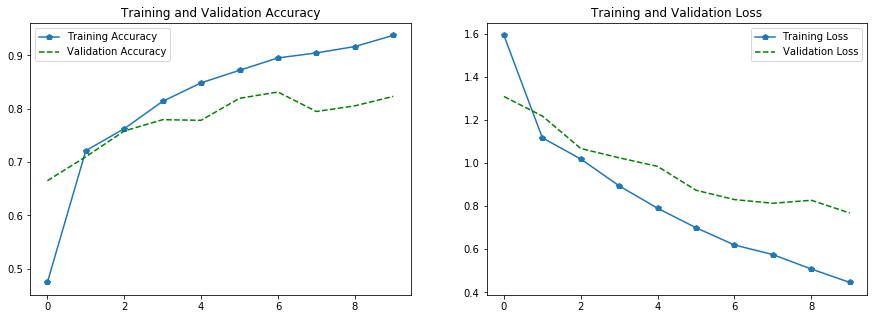

In [0]:
# Plot the training graph
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'p-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'g--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'p-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'g--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    
plot_training(history)

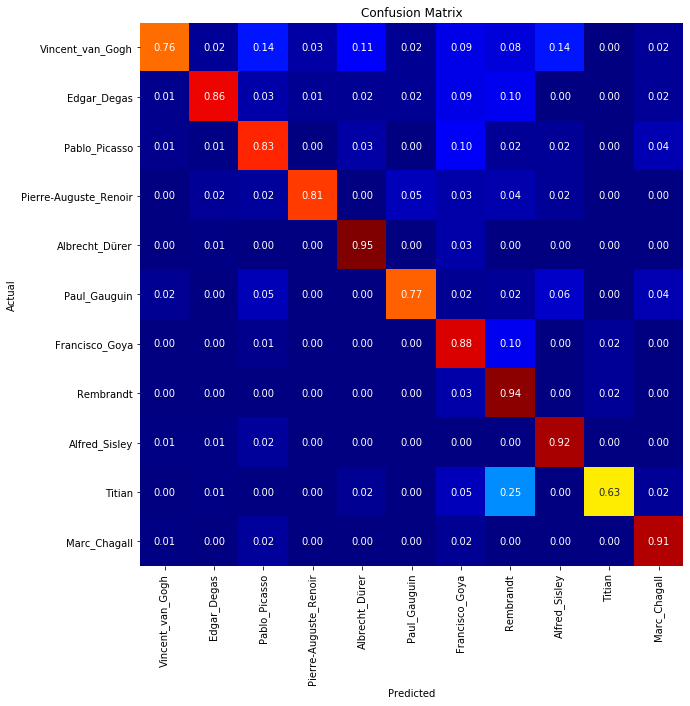

Classification Report:
                       precision    recall  f1-score   support

     Vincent_van_Gogh       0.94      0.76      0.84       174
          Edgar_Degas       0.92      0.86      0.89       138
        Pablo_Picasso       0.73      0.83      0.78        87
Pierre-Auguste_Renoir       0.95      0.81      0.87        67
       Albrecht_Dürer       0.85      0.95      0.90        65
         Paul_Gauguin       0.90      0.77      0.83        61
       Francisco_Goya       0.65      0.88      0.75        58
            Rembrandt       0.61      0.94      0.74        52
        Alfred_Sisley       0.79      0.92      0.85        50
               Titian       0.94      0.63      0.75        51
         Marc_Chagall       0.85      0.91      0.88        45

             accuracy                           0.83       848
            macro avg       0.83      0.84      0.83       848
         weighted avg       0.85      0.83      0.83       848



In [0]:
# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

tick_labels = artists_top_name.tolist()

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=artists_top_name.tolist()))

showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)

### Xception

In [0]:
# Load pre-trained model
base_model = Xception(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

83689472/83683744 [==============================] - 1s 0us/step


In [0]:
# Add layers at the end
X = base_model.output
X = tf.keras.layers.Flatten()(X)

X = tf.keras.layers.Dense(512, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Activation('relu')(X)

X = tf.keras.layers.Dense(16, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Activation('relu')(X)

output = tf.keras.layers.Dense(n_classes, activation='softmax')(X)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [0]:
optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [0]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [0]:
history = model.fit_generator(
    generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
    epochs=10,
    shuffle=True,
    verbose=1,
    callbacks=[reduce_lr],
    use_multiprocessing=True,
    workers=16,
    class_weight=class_weights
)

Epoch 1/10
215/215 [==============================] - 94s 437ms/step - loss: 1.7628 - acc: 0.4174 - val_loss: 1.4998 - val_acc: 0.5601
Epoch 2/10
215/215 [==============================] - 87s 405ms/step - loss: 1.2694 - acc: 0.6774 - val_loss: 1.2459 - val_acc: 0.7170
Epoch 3/10
215/215 [==============================] - 88s 412ms/step - loss: 1.0620 - acc: 0.7655 - val_loss: 1.1627 - val_acc: 0.7583
Epoch 4/10
215/215 [==============================] - 89s 413ms/step - loss: 0.9221 - acc: 0.8232 - val_loss: 1.0806 - val_acc: 0.7901
Epoch 5/10
215/215 [==============================] - 90s 419ms/step - loss: 0.8150 - acc: 0.8524 - val_loss: 1.0274 - val_acc: 0.8101
Epoch 6/10
215/215 [==============================] - 91s 424ms/step - loss: 0.7114 - acc: 0.8910 - val_loss: 0.9728 - val_acc: 0.8054
Epoch 7/10
215/215 [==============================] - 92s 429ms/step - loss: 0.6544 - acc: 0.8996 - val_loss: 0.9242 - val_acc: 0.8137
Epoch 8/10
215/215 [==============================] - 9

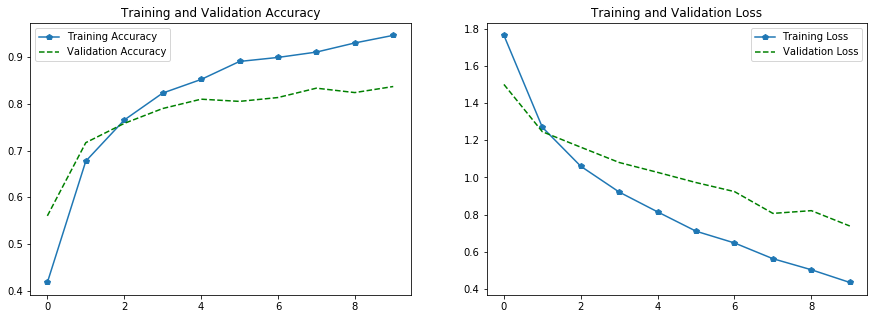

In [0]:
# Plot the training graph
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'p-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'g--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'p-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'g--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    
plot_training(history)

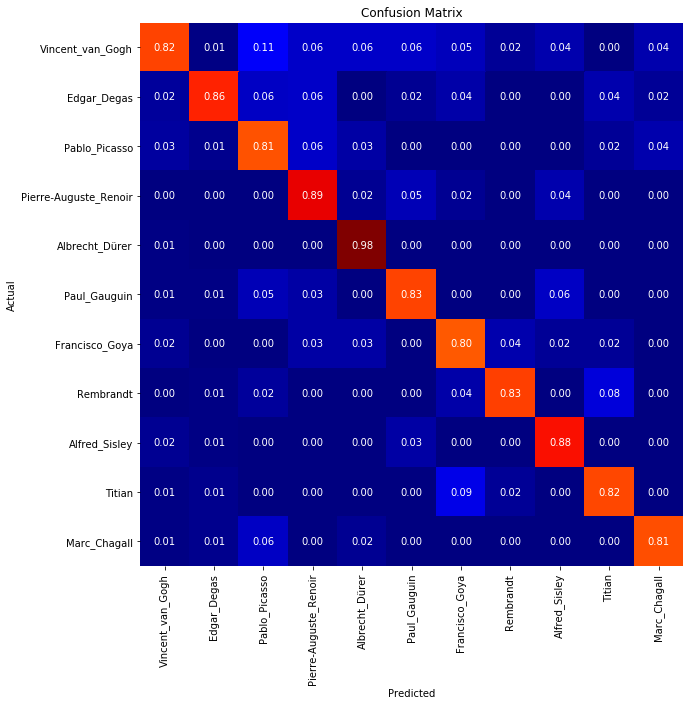

Classification Report:
                       precision    recall  f1-score   support

     Vincent_van_Gogh       0.88      0.82      0.85       170
          Edgar_Degas       0.92      0.86      0.89       137
        Pablo_Picasso       0.73      0.81      0.77        84
Pierre-Auguste_Renoir       0.78      0.89      0.83        65
       Albrecht_Dürer       0.86      0.98      0.92        64
         Paul_Gauguin       0.84      0.83      0.83        63
       Francisco_Goya       0.78      0.80      0.79        56
            Rembrandt       0.91      0.83      0.87        52
        Alfred_Sisley       0.85      0.88      0.86        50
               Titian       0.84      0.82      0.83        50
         Marc_Chagall       0.89      0.81      0.85        48

             accuracy                           0.85       839
            macro avg       0.84      0.85      0.84       839
         weighted avg       0.85      0.85      0.85       839



In [0]:
# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

tick_labels = artists_top_name.tolist()

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=artists_top_name.tolist()))

showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)